# Lab assignment: fraud detection through ensemble methods

<img src="img/fraud.jpg" style="width:600px;">

In this assignment we will use all the skills in ensemble learning we acquired from previous exercises to build a an automated fraud detection system.

**Students**:
* Mireya Gutiérrez Castro
* Claudia Quintana Wong

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed. Both correctness of the solution and code quality will be taken into account for marking.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment. You are not expected to write any solution, but you should pay attention to them to understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary excercise that can help you gain a deeper knowledge into the topic. This exercise won't be taken into account towards marking, but you are encouraged to undertake it. Good luck!</td></tr>
</table>

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.random.seed(42)
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data loading

The data for this problem is included in the *data* folder, with separate files for training and test data. Each file includes several unidentified explanatory features, together with an "Amount" feature and the target "Class". Fraudulent operations are marked as Class == 1.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Load the training and test data into Pandas DataFrames with names <b>train</b> and <b>test</b>, respectively.
 </td></tr>
</table>

In [2]:
import pandas as pd
train = pd.read_csv("./data/fraud_train.csv", sep = ',')
test = pd.read_csv ("./data/fraud_test.csv", sep = ',')
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Perform a brief analysis of the training data to answer the following questions: how many explanatory variables do you have? What is the distribution of classes?
 </td></tr>
</table>

In [3]:
print("train dimension:" ,train.shape)
print("test dimension:" ,test.shape)
X_train, y_train = train.drop(["Class"], axis=1), train["Class"]
X_test, y_test = test.drop(["Class"], axis=1), test["Class"]
print("number of explanatory variables:", X_train.shape[1])
print("number of fraudulent operations:" , len(y_train[y_train==1]))
print("number of not fraudulent operations:", len(y_train[y_train==0]))

train dimension: (5246, 30)
test dimension: (5246, 30)
number of explanatory variables: 29
number of fraudulent operations: 246
number of not fraudulent operations: 5000


4,7% are fraudulent transactions which suggests this could be intepreted as an Anomaly Detection problem. In the next section, we are going to implement some supervised and unsupervised models which will be compared in terms of ROC AUC score in order to validate the anomaly detection assumption.

## Measuring the performance of a fraud detector

Fraudulent activities are usually prosecuted, therefore fraudsters need to be creative and come up constantly with new ways of performing fraud. Furthermore, frauds are scarce (fortunately), and so we have few positive class patterns available for training. This means the problem is highly unbalanced, which is a problem for training good models, but is also a problem for the model evaluation. 

Consider a dumb model that classifies all data as negative (non-fraud). We can simulate the predictions of this model by creating a predictions vector of all zeros:

In [4]:
dumbpreds = [0] * len(test)

Let's measure the accuracy of this model

In [5]:
from sklearn.metrics import accuracy_score

dump_score = accuracy_score(test["Class"], dumbpreds)
print(f"Dump model accuracy {round(dump_score, 3)}")

Dump model accuracy 0.953


Yo should have obtained a 95% of accuracy, because most of the patterns are indeed negative. But this would be totally useless as a fraud detector! Therefore, we need a better metric.

One that works well for heavily unbalanced problems is the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), or AUC in short. In scikit-learn this metric is readily available, and we can test how this reveals the poor performance of this dumb model

In [6]:
from sklearn.metrics import roc_auc_score

dump_roc_auc_score = roc_auc_score(test["Class"], dumbpreds)
print(f"Dump model ROC AUC {round(dump_roc_auc_score, 3)}")

Dump model ROC AUC 0.5


An AUC of 50% means the model is no better than a random guess. We should aim to maximize this metric and attain a 100%, meaning all fraudulent patterns obtain higher scores than non-fraud patterns.

## Unsupervised fraud detector

Since we now we have scarce positive data, it might make sense to start building an unsupervised fraud detector.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Using <b>only the training data</b>, create an Isolation Forest model for anomaly detection. You can use the number of positive patterns in the data to adjust the contamination ratio. Then measure the performance of the model on the test set, in terms of AUC score.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Note the roc_auc_score metric must receive <b>positive class probabilities</b>. It is not possible to obtain these probabilities from an IsolationForest model, but you can make use of its decision_function method to obtain normality scores (average tree depth), which can be negated to obtain positive class scores.
 </td></tr>
</table>

In [7]:
from sklearn.ensemble import IsolationForest

In [8]:
anomaly_detection = IsolationForest(contamination=len(y_train[y_train==1])/len(y_train))
anomaly_detection.fit(X_train)

IsolationForest(contamination=0.04689287075867327)

In [9]:
preds = anomaly_detection.predict(X_test)
idx_anomalies = np.where(preds == -1)

print("Number of anomalies or fraud in test:" ,len(y_test[y_test==1]))
print("Number of no anomalies or no fraud in test:" ,len(y_test[y_test==0]))
print("Number of good predictions of fraud in test:" ,sum(y_test[idx_anomalies[0]]==1))

Number of anomalies or fraud in test: 246
Number of no anomalies or no fraud in test: 5000
Number of good predictions of fraud in test: 160


In [10]:
test_decision_function = anomaly_detection.decision_function(X_test)
len(test_decision_function[test_decision_function<0])
unsupervised_roc_auc_score = roc_auc_score(y_test,-test_decision_function)
print(f"The performance of the model on the test set, in terms of AUC score is: {round(unsupervised_roc_auc_score, 3)}")

The performance of the model on the test set, in terms of AUC score is: 0.948


<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Create a visualization showing the performance of this model over the test data. Suggestion: make use of the <a href=https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html>ROC plot portrayed in the scikit-learn docs</a>
 </td></tr>
</table>

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, -test_decision_function)
roc_auc = auc(fpr, tpr)
roc_auc   

0.9479227642276422

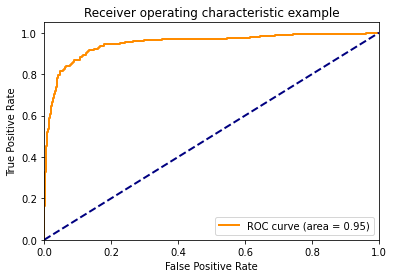

In [12]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Supervised models

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Let's check now whether we can improve the results using supervised models, that is, models that exploit the Class information available in the training data. Try <b>at least five</b> ensemble-based classification models, <b>using only the data in the training set</b>.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
Some suggestions on the scikit-learn models you can use are: Random Forest, Extra Trees, AdaBoost, Gradient Boosting, Bagging, Voting and Stacking. You can also use an XGBClassifier, also included in this environment.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Bonus points will we awarded for:
     <ul>
         <li>Trying more ensemble strategies beyond the minimum requirement of five.</li>
         <li>Improving the AUC score of your best model as much as possible.</li>
         <li>Trying <a href=https://catboost.ai/>CatBoost</a> and/or <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a>, other two popular ensemble methods. Note you will need to install these in your environment.</li>
     </ul>
 </td></tr>
</table>

In this section, several supervised classifiers will be implemented. Initially, some base models will be trained, tested and compared with same models but using Random Search to adjust hyperparameters. Futhermore, some learning techniques as Bagging, Boosting, Voting and Stacking will also be used. Finally, results from each executed model will be compared.

In [13]:
####### INSERT YOUR CODE HERE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

base_learners = [    
    ('sgd', SGDClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('nb', GaussianNB()),
    ('xt', ExtraTreesClassifier()), 
    ('xgb', XGBClassifier()),
    ('gb', GradientBoostingClassifier())
]

In [14]:
roc_auc_scores = {}
for mod_name, mod_obj in base_learners:
    mod_obj.fit(X_train, y_train)
    preds = mod_obj.predict(X_test)
    score = roc_auc_score(y_test, preds)
    roc_auc_scores[mod_name] = score
    
base_roc_auc_scores = pd.DataFrame.from_dict(data = roc_auc_scores, orient='index')
base_roc_auc_scores

,0
sgd,0.839331
dt,0.913929
rf,0.916667
nb,0.897702
xt,0.908537
xgb,0.912302
gb,0.922797


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier


ESTIMS = 50

models = {
    "sgd": {
        "class" : SGDClassifier(),
        "param_dist" : {
            "loss" : ['hinge', 'log'],            
            "max_iter": [1000, 5000]
        }
    },
    "descisionTree": {
        "class" : DecisionTreeClassifier(),
        "param_dist" : {
            "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],            
            "criterion": ["gini", "entropy"]
        }
    },
    "randomForest": {
        "class" : RandomForestClassifier(),
        "param_dist" : {
            "n_estimators" : [ESTIMS],
            "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"]
        }
    },
    "gaussianNB": {
        "class" : GaussianNB(),
        "param_dist" : {
        }
    },   
    "extraTree": {
        "class" : ExtraTreesClassifier(),
        "param_dist" : {
            "n_estimators" : [ESTIMS],
            "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"]
        }
    }, 
    "xgb": {
        "class" : XGBClassifier(),
        "param_dist" : {
            'n_estimators': [ESTIMS],
            'gamma' : [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
            'max_depth': [6, 9, 12],
            'subsample': [0.5, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.9, 1.0],
            'reg_lambda' : [0, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        }
    },
    "gradientBoosting": {
        "class" : GradientBoostingClassifier(),
        "param_dist" : {
            "n_estimators" : [ESTIMS],
            "loss": ["deviance", "exponential"],
            "learning_rate": np.logspace(-5,0,12),
            "max_depth": [3, 5, 10, 15, 20, 25, 30, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64],
            "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
            "subsample" : [0.1, 0.2, 0.5, 0.9, 1],
            "max_features": ["sqrt", "log2", None],
        }
    },
}

In [16]:
for model_name, model in models.items():
    print(f'Training {model_name}...')    
    estimator = model['class']
    search = RandomizedSearchCV(estimator, 
                                param_distributions=model['param_dist'], 
                                n_iter=50, 
                                n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)
    roc_auc = roc_auc_score(y_test, preds)
    print(f'{model_name} ROC AUC: {round(roc_auc, 3)}')
    print()

Training sgd...


C:\Users\tec005m\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


sgd ROC AUC: 0.918

Training descisionTree...
descisionTree ROC AUC: 0.904

Training randomForest...
randomForest ROC AUC: 0.919

Training gaussianNB...
gaussianNB ROC AUC: 0.898

Training extraTree...


C:\Users\tec005m\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


extraTree ROC AUC: 0.918

Training xgb...
xgb ROC AUC: 0.91

Training gradientBoosting...
gradientBoosting ROC AUC: 0.91



After executing Randomized Search over the same models set, we can observe that the models reach better performance with default parameters. For this reason, we are going to use the models with the default parameters to develop bagging and boosting approaches. 

### Bagging and Boosting

In [17]:
from sklearn.ensemble import BaggingClassifier

bagging_roc_auc_data = {}
for mod_name, mod_obj in base_learners:
    bagging_model = BaggingClassifier(base_estimator=mod_obj, n_estimators=ESTIMS, n_jobs=-1)
    bagging_model.fit(X_train, y_train)
    preds = bagging_model.predict(X_test)
    score = roc_auc_score(y_test, preds)
    bagging_roc_auc_data[f'bag_{mod_name}'] = score
    
bagging_roc_auc_scores = pd.DataFrame.from_dict(data = bagging_roc_auc_data, orient='index')
bagging_roc_auc_scores

,0
bag_sgd,0.861589
bag_dt,0.924097
bag_rf,0.916667
bag_nb,0.901667
bag_xt,0.904472
bag_xgb,0.916567
bag_gb,0.918499


In [18]:
from sklearn.ensemble import AdaBoostClassifier

boosting_roc_auc_data = {}
for mod_name, mod_obj in base_learners:
    boosting_model = AdaBoostClassifier(base_estimator=mod_obj, n_estimators=ESTIMS, algorithm='SAMME')
    boosting_model.fit(X_train, y_train)
    preds = boosting_model.predict(X_test)
    score = roc_auc_score(y_test, preds)
    boosting_roc_auc_data[f'boost_{mod_name}'] = score
    
boosting_roc_auc_scores = pd.DataFrame.from_dict(data=boosting_roc_auc_data, orient='index')
boosting_roc_auc_scores

,0
boost_sgd,0.884146
boost_dt,0.929924
boost_rf,0.916667
boost_nb,0.897702
boost_xt,0.902439
boost_xgb,0.500000
boost_gb,0.926562


### CatBoost

In [19]:
#!pip install catboost

In [20]:
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier()
model.fit(X_train, y_train)
preds_class = model.predict(X_test)
catboost_roc_auc = roc_auc_score(y_test, preds_class)
print(f"CatBoost ROC AUC: {round(catboost_roc_auc, 3)}")

Learning rate set to 0.020907
0:	learn: 0.6434662	total: 139ms	remaining: 2m 18s
1:	learn: 0.6025578	total: 146ms	remaining: 1m 12s
2:	learn: 0.5584346	total: 153ms	remaining: 50.8s
3:	learn: 0.5196250	total: 159ms	remaining: 39.7s
4:	learn: 0.4842882	total: 166ms	remaining: 33s
5:	learn: 0.4530421	total: 172ms	remaining: 28.5s
6:	learn: 0.4224285	total: 178ms	remaining: 25.2s
7:	learn: 0.3956283	total: 185ms	remaining: 22.9s
8:	learn: 0.3697373	total: 191ms	remaining: 21s
9:	learn: 0.3468621	total: 197ms	remaining: 19.5s
10:	learn: 0.3232493	total: 203ms	remaining: 18.2s
11:	learn: 0.3015552	total: 209ms	remaining: 17.2s
12:	learn: 0.2833977	total: 215ms	remaining: 16.3s
13:	learn: 0.2652614	total: 221ms	remaining: 15.5s
14:	learn: 0.2495479	total: 226ms	remaining: 14.9s
15:	learn: 0.2339725	total: 232ms	remaining: 14.3s
16:	learn: 0.2192074	total: 238ms	remaining: 13.8s
17:	learn: 0.2077479	total: 244ms	remaining: 13.3s
18:	learn: 0.1956579	total: 250ms	remaining: 12.9s
19:	learn: 0.

187:	learn: 0.0192543	total: 1.27s	remaining: 5.49s
188:	learn: 0.0191951	total: 1.28s	remaining: 5.48s
189:	learn: 0.0191429	total: 1.28s	remaining: 5.47s
190:	learn: 0.0190875	total: 1.29s	remaining: 5.46s
191:	learn: 0.0190557	total: 1.29s	remaining: 5.45s
192:	learn: 0.0190226	total: 1.3s	remaining: 5.44s
193:	learn: 0.0189591	total: 1.31s	remaining: 5.43s
194:	learn: 0.0188708	total: 1.31s	remaining: 5.42s
195:	learn: 0.0187750	total: 1.32s	remaining: 5.41s
196:	learn: 0.0187056	total: 1.32s	remaining: 5.4s
197:	learn: 0.0186671	total: 1.33s	remaining: 5.38s
198:	learn: 0.0186073	total: 1.33s	remaining: 5.38s
199:	learn: 0.0185744	total: 1.34s	remaining: 5.36s
200:	learn: 0.0185556	total: 1.35s	remaining: 5.35s
201:	learn: 0.0185241	total: 1.35s	remaining: 5.34s
202:	learn: 0.0184538	total: 1.36s	remaining: 5.33s
203:	learn: 0.0183403	total: 1.36s	remaining: 5.32s
204:	learn: 0.0183001	total: 1.37s	remaining: 5.31s
205:	learn: 0.0182510	total: 1.38s	remaining: 5.3s
206:	learn: 0.0

371:	learn: 0.0114812	total: 2.35s	remaining: 3.98s
372:	learn: 0.0114438	total: 2.36s	remaining: 3.97s
373:	learn: 0.0114240	total: 2.37s	remaining: 3.96s
374:	learn: 0.0114136	total: 2.37s	remaining: 3.95s
375:	learn: 0.0113696	total: 2.38s	remaining: 3.95s
376:	learn: 0.0113510	total: 2.38s	remaining: 3.94s
377:	learn: 0.0113406	total: 2.39s	remaining: 3.93s
378:	learn: 0.0112712	total: 2.4s	remaining: 3.92s
379:	learn: 0.0112431	total: 2.4s	remaining: 3.92s
380:	learn: 0.0112208	total: 2.41s	remaining: 3.91s
381:	learn: 0.0111813	total: 2.41s	remaining: 3.9s
382:	learn: 0.0111666	total: 2.42s	remaining: 3.9s
383:	learn: 0.0111561	total: 2.42s	remaining: 3.89s
384:	learn: 0.0111417	total: 2.43s	remaining: 3.88s
385:	learn: 0.0111293	total: 2.44s	remaining: 3.88s
386:	learn: 0.0111182	total: 2.44s	remaining: 3.87s
387:	learn: 0.0111029	total: 2.45s	remaining: 3.86s
388:	learn: 0.0110769	total: 2.45s	remaining: 3.85s
389:	learn: 0.0110545	total: 2.46s	remaining: 3.85s
390:	learn: 0.01

555:	learn: 0.0079019	total: 3.44s	remaining: 2.75s
556:	learn: 0.0078967	total: 3.45s	remaining: 2.74s
557:	learn: 0.0078932	total: 3.45s	remaining: 2.73s
558:	learn: 0.0078595	total: 3.46s	remaining: 2.73s
559:	learn: 0.0078524	total: 3.46s	remaining: 2.72s
560:	learn: 0.0078499	total: 3.47s	remaining: 2.71s
561:	learn: 0.0078419	total: 3.48s	remaining: 2.71s
562:	learn: 0.0078251	total: 3.48s	remaining: 2.7s
563:	learn: 0.0078200	total: 3.49s	remaining: 2.7s
564:	learn: 0.0078118	total: 3.49s	remaining: 2.69s
565:	learn: 0.0077873	total: 3.5s	remaining: 2.68s
566:	learn: 0.0077646	total: 3.5s	remaining: 2.68s
567:	learn: 0.0077512	total: 3.51s	remaining: 2.67s
568:	learn: 0.0077487	total: 3.52s	remaining: 2.66s
569:	learn: 0.0077376	total: 3.52s	remaining: 2.66s
570:	learn: 0.0077062	total: 3.53s	remaining: 2.65s
571:	learn: 0.0076814	total: 3.53s	remaining: 2.64s
572:	learn: 0.0076784	total: 3.54s	remaining: 2.64s
573:	learn: 0.0076750	total: 3.55s	remaining: 2.63s
574:	learn: 0.00

734:	learn: 0.0055359	total: 4.52s	remaining: 1.63s
735:	learn: 0.0055246	total: 4.53s	remaining: 1.62s
736:	learn: 0.0055215	total: 4.54s	remaining: 1.62s
737:	learn: 0.0055159	total: 4.54s	remaining: 1.61s
738:	learn: 0.0055017	total: 4.55s	remaining: 1.61s
739:	learn: 0.0054856	total: 4.56s	remaining: 1.6s
740:	learn: 0.0054732	total: 4.57s	remaining: 1.59s
741:	learn: 0.0054670	total: 4.57s	remaining: 1.59s
742:	learn: 0.0054522	total: 4.58s	remaining: 1.58s
743:	learn: 0.0054355	total: 4.58s	remaining: 1.58s
744:	learn: 0.0054197	total: 4.59s	remaining: 1.57s
745:	learn: 0.0054118	total: 4.6s	remaining: 1.57s
746:	learn: 0.0054045	total: 4.61s	remaining: 1.56s
747:	learn: 0.0053997	total: 4.61s	remaining: 1.55s
748:	learn: 0.0053896	total: 4.62s	remaining: 1.55s
749:	learn: 0.0053857	total: 4.63s	remaining: 1.54s
750:	learn: 0.0053774	total: 4.63s	remaining: 1.54s
751:	learn: 0.0053672	total: 4.64s	remaining: 1.53s
752:	learn: 0.0053547	total: 4.64s	remaining: 1.52s
753:	learn: 0.

923:	learn: 0.0040786	total: 5.65s	remaining: 465ms
924:	learn: 0.0040710	total: 5.66s	remaining: 459ms
925:	learn: 0.0040628	total: 5.66s	remaining: 452ms
926:	learn: 0.0040549	total: 5.67s	remaining: 446ms
927:	learn: 0.0040499	total: 5.67s	remaining: 440ms
928:	learn: 0.0040437	total: 5.68s	remaining: 434ms
929:	learn: 0.0040406	total: 5.68s	remaining: 428ms
930:	learn: 0.0040329	total: 5.69s	remaining: 422ms
931:	learn: 0.0040310	total: 5.7s	remaining: 416ms
932:	learn: 0.0040235	total: 5.7s	remaining: 409ms
933:	learn: 0.0040163	total: 5.71s	remaining: 403ms
934:	learn: 0.0040154	total: 5.71s	remaining: 397ms
935:	learn: 0.0040126	total: 5.72s	remaining: 391ms
936:	learn: 0.0040049	total: 5.72s	remaining: 385ms
937:	learn: 0.0039982	total: 5.73s	remaining: 379ms
938:	learn: 0.0039781	total: 5.74s	remaining: 373ms
939:	learn: 0.0039693	total: 5.74s	remaining: 367ms
940:	learn: 0.0039659	total: 5.75s	remaining: 360ms
941:	learn: 0.0039570	total: 5.75s	remaining: 354ms
942:	learn: 0.

### Voting

In [21]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=base_learners, n_jobs=-1)
voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)
voting_roc_auc_score = roc_auc_score(y_test,voting_preds)
print(f"Voting ROC AUC: {round(voting_roc_auc_score, 3)}")

Voting ROC AUC: 0.915


### Stacking

In [22]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(estimators=base_learners, n_jobs=-1)
stacking_model.fit(X_train, y_train)
stacking_preds = stacking_model.predict(X_test)
stacking_roc_auc_score = roc_auc_score(y_test, stacking_preds)
print(f"Stacking ROC AUC: {round(stacking_roc_auc_score, 3)}")

Stacking ROC AUC: 0.918


<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Now create a visualization showing the performance of your supervised models on the test set, together with the unsupervised model. Has the performance improved after making use of the Class data? Which model obtains the best AUC?
 </td></tr>
</table>

In [23]:
all_models = {
    'base': base_roc_auc_scores.iloc[:,0].values,
    'bagging': bagging_roc_auc_scores.iloc[:,0].values,
    'boosting': boosting_roc_auc_scores.iloc[:,0].values     
}

all_scores = pd.DataFrame.from_dict(data=all_models).transpose()
all_scores.columns = ['sgd', 'dt', 'rf', 'nb', 'xt', 'xgb', 'gb']
all_scores

,sgd,dt,rf,nb,xt,xgb,gb
base,0.839331,0.913929,0.916667,0.897702,0.908537,0.912302,0.922797
bagging,0.861589,0.924097,0.916667,0.901667,0.904472,0.916567,0.918499
boosting,0.884146,0.929924,0.916667,0.897702,0.902439,0.500000,0.926562


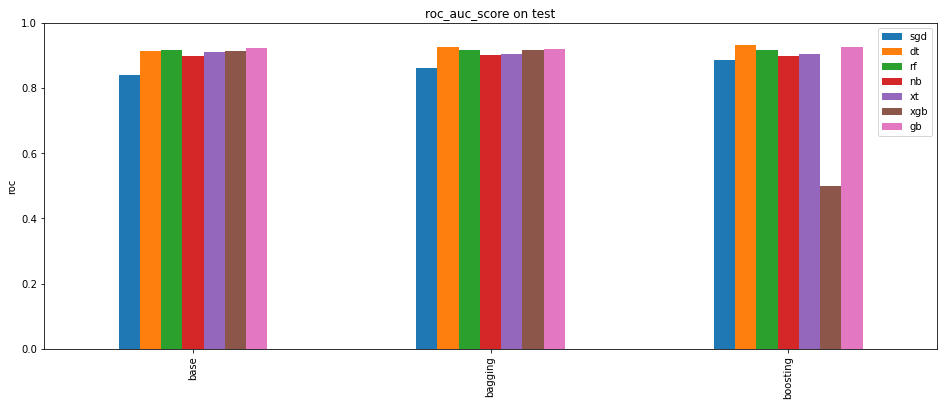

In [24]:
ax = all_scores.plot(kind='bar', title='roc_auc_score on test', ylim=(0.0, 1.0), figsize=(16, 6)).set_ylabel('roc');

In the image below, it can be observed, that there is no great difference between the differents approaches implemented because they have very similar scores. We think that the election of which model should be used depend on the situation, as bagging and boosting do not reach a much higher performance, it can be a good idea to use base models that takes less time to train.

## Comparing models

In [25]:
d = {
    'unsupervised': [unsupervised_roc_auc_score],
    'voting': [voting_roc_auc_score],
    'stacking': [stacking_roc_auc_score],
    'catboosting': [catboost_roc_auc]
}
df = pd.DataFrame(data=d).transpose()

_all = pd.concat([base_roc_auc_scores, bagging_roc_auc_scores, boosting_roc_auc_scores, df])
_all.columns = ['roc_auc']
ranking = _all.sort_values(by='roc_auc', ascending=False)
ranking

,roc_auc
unsupervised,0.947923
boost_dt,0.929924
boost_gb,0.926562
bag_dt,0.924097
gb,0.922797
bag_gb,0.918499
stacking,0.918399
rf,0.916667
bag_rf,0.916667
boost_rf,0.916667


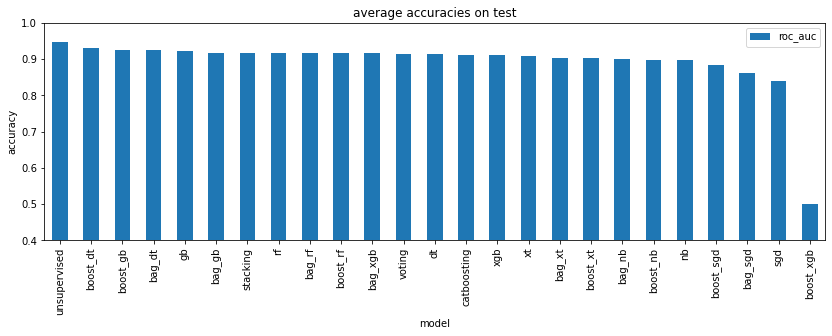

In [26]:
ax = ranking.plot(kind='bar', title='average accuracies on test', ylim=(0.4, 1), figsize=(14, 4))
ax.set_ylabel('accuracy')
ax.set_xlabel('model');

In this case, the model that achieves the best performance is the unsupervised one. This may be due to the fact that we are in the presence of an unbalanced dataset and positive cases can be interpreted as anomalies. Although the roc auc measure takes into account the class distribution, the supervised models give the same weight to each class without taking into account the imbalance of the classes. This demonstrates that the assumption expresed before is true and this problems can be interpreted as an Anomaly Detection problem.